# GTFS - General Transit Feed Specification
Directorio de Transporte Público Metropolitano

Este notebook trabaja con datos de transporte público en formato GTFS (General Transit Feed Specification) del Directorio de Transporte Público Metropolitano. Se centra en cargar, limpiar y procesar la información de paradas y rutas. Las ubicaciones de las paradas se convierten a un formato geoespacial (GeoDataFrame). A modo de ejemplo se filtran para una comuna específica (Santiago) y finalmente se visualizan en un mapa.

In [75]:
# Imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

In [ ]:
# Archivos GTFS
archivos_gtfs = [
    "agency.txt",
    "calendar_dates.txt",
    "calendar.txt",
    "feed_info.txt",
    "frequencies.txt",
    "pathways.txt",
    "routes.txt",
    "shapes.txt",
    "stop_times.txt",
    "stops.txt",
    "transfers.txt",
    "trips.txt"
]

In [109]:
# 1. Creamos un diccionario para almacenar los DataFrames
dataframes = {}

# 2. Iteramos sobre los archivos
for archivo in archivos_gtfs:

    #2.1 Creamos la ruta temporal del archivo
    path = os.path.join("GTFS", archivo)

    #2.2 Asignamos el nombre del DataFrame
    nombre_df = archivo.replace(".txt", "")

    #2.3 Creamos el DataFrame y lo añadimos al diccionario
    df = pd.read_csv(path)
    df_dict = {nombre_df: df}
    dataframes.update(df_dict)
    
print(dataframes.keys())

dict_keys(['agency', 'calendar_dates', 'calendar', 'feed_info', 'frequencies', 'pathways', 'routes', 'shapes', 'stop_times', 'stops', 'transfers', 'trips'])


In [110]:
# Renombramos los DataFrames a utilizar para facilitar su uso
df_paradas = dataframes["stops"]
df_rutas = dataframes["routes"]
df_agencias = dataframes["agency"]

In [111]:
df_paradas.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,wheelchair_boarding,location_type,parent_station
0,PB299,NaN,PB299-Avenida Recoleta / esq. Industrial,-33.380778,-70.639574,NaN,0.0,NaN,NaN
1,PB300,NaN,PB300-Avenida Recoleta / esq. Av. A. Vespucio,-33.382476,-70.640274,NaN,0.0,NaN,NaN
2,PB1369,NaN,PB1369-Avenida Recoleta / esq. Oscar Castro,-33.384572,-70.641079,NaN,0.0,NaN,NaN
3,PB301,NaN,PB301-Avenida Recoleta / esq. M. Luisa Bombal,-33.386007,-70.641694,NaN,0.0,NaN,NaN
4,PB302,NaN,PB302-Avenida Recoleta / esq. Alfredo Rosende,-33.388346,-70.642364,NaN,0.0,NaN,NaN


# Limpieza:

# DataFrame de Paradas

In [23]:
#1. Eliminamos las filas con valores nulos en latitud y longitud
df_paradas = df_paradas.dropna(subset = ["stop_lat", "stop_lon"])
df_paradas.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,wheelchair_boarding,location_type,parent_station
0,PB299,NaN,PB299-Avenida Recoleta / esq. Industrial,-33.380778,-70.639574,NaN,0.0,NaN,NaN
1,PB300,NaN,PB300-Avenida Recoleta / esq. Av. A. Vespucio,-33.382476,-70.640274,NaN,0.0,NaN,NaN
2,PB1369,NaN,PB1369-Avenida Recoleta / esq. Oscar Castro,-33.384572,-70.641079,NaN,0.0,NaN,NaN
3,PB301,NaN,PB301-Avenida Recoleta / esq. M. Luisa Bombal,-33.386007,-70.641694,NaN,0.0,NaN,NaN
4,PB302,NaN,PB302-Avenida Recoleta / esq. Alfredo Rosende,-33.388346,-70.642364,NaN,0.0,NaN,NaN


In [24]:
#2. Eliminamos las columnas innecesarias
columnas_a_eliminar = ["stop_code", "stop_url", "wheelchair_boarding"]
df_paradas = df_paradas.drop(columns = columnas_a_eliminar)
df_paradas.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,PB299,PB299-Avenida Recoleta / esq. Industrial,-33.380778,-70.639574,NaN,NaN
1,PB300,PB300-Avenida Recoleta / esq. Av. A. Vespucio,-33.382476,-70.640274,NaN,NaN
2,PB1369,PB1369-Avenida Recoleta / esq. Oscar Castro,-33.384572,-70.641079,NaN,NaN
3,PB301,PB301-Avenida Recoleta / esq. M. Luisa Bombal,-33.386007,-70.641694,NaN,NaN
4,PB302,PB302-Avenida Recoleta / esq. Alfredo Rosende,-33.388346,-70.642364,NaN,NaN


# DataFrame de Rutas

In [25]:
#1. Eliminamos los valores con ID de agencia nulos
df_rutas = df_rutas.dropna(subset = ["agency_id"])
df_rutas.head()


,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,101,RM,101,Recoleta - Cerrillos,NaN,3,NaN,AF2B1E,FFFFFF
1,102,RM,102,(M) Las Rejas - San Carlos Oriente,NaN,3,NaN,AF2B1E,FFFFFF
2,103,RM,103,Providencia - San Luis De Macul,NaN,3,NaN,AF2B1E,FFFFFF
3,104,RM,104,Providencia - Camilo Henriquez,NaN,3,NaN,AF2B1E,FFFFFF
4,105,RM,105,Renca - Lo Espejo,NaN,3,NaN,AF2B1E,FFFFFF


In [26]:
#2. Creamos una nueva columna con el tipo de transporte
condiciones = [
        (df_rutas['agency_id'] == 'M'),    # Metro de Santiago
        (df_rutas['agency_id'] == 'MT'),   # EFE Trenes de Chile
        (df_rutas['agency_id'] == 'RM'),   # Red Metropolitana (Buses)
        (df_rutas['agency_id'] == 'BAA')   # Bus Aeropuerto
    ]
df_rutas["tipo_transporte"] = np.select(condiciones, ["Metro", "Tren", "Micro", "Bus"], default = "Otro")

In [27]:
#3. Reordenamos el DataFrame
df_rutas = df_rutas[["route_id", "agency_id", "tipo_transporte", "route_short_name", "route_long_name", "route_type", "route_color", "route_text_color"]]
df_rutas.head()

,route_id,agency_id,tipo_transporte,route_short_name,route_long_name,route_type,route_color,route_text_color
0,101,RM,Micro,101,Recoleta - Cerrillos,3,AF2B1E,FFFFFF
1,102,RM,Micro,102,(M) Las Rejas - San Carlos Oriente,3,AF2B1E,FFFFFF
2,103,RM,Micro,103,Providencia - San Luis De Macul,3,AF2B1E,FFFFFF
3,104,RM,Micro,104,Providencia - Camilo Henriquez,3,AF2B1E,FFFFFF
4,105,RM,Micro,105,Renca - Lo Espejo,3,AF2B1E,FFFFFF


# Mapa de Paradas

In [28]:
#1. Definimos la geometría a partir de las columnas de longitud y latitud.
geometria = gpd.points_from_xy(df_paradas["stop_lon"], df_paradas["stop_lat"])

gdf = gpd.GeoDataFrame(df_paradas, geometry = geometria, crs = "EPSG:4326")

gdf.head(5)

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,geometry
0,PB299,PB299-Avenida Recoleta / esq. Industrial,-33.380778,-70.639574,NaN,NaN,POINT (-70.63957 -33.38078)
1,PB300,PB300-Avenida Recoleta / esq. Av. A. Vespucio,-33.382476,-70.640274,NaN,NaN,POINT (-70.64027 -33.38248)
2,PB1369,PB1369-Avenida Recoleta / esq. Oscar Castro,-33.384572,-70.641079,NaN,NaN,POINT (-70.64108 -33.38457)
3,PB301,PB301-Avenida Recoleta / esq. M. Luisa Bombal,-33.386007,-70.641694,NaN,NaN,POINT (-70.64169 -33.38601)
4,PB302,PB302-Avenida Recoleta / esq. Alfredo Rosende,-33.388346,-70.642364,NaN,NaN,POINT (-70.64236 -33.38835)


In [29]:
#2. Verificamos el CRS
print("CRS:", gdf.crs)

CRS: EPSG:4326


In [44]:
#3. Cargamos el shapefile con las comunas de Chile
path_comunas = os.path.join("Comunas", "Comunas.shp")
comunas = gpd.read_file(path_comunas)

#4. Verificamos el CRS del shapefile
print("CRS:", comunas.crs)

CRS: EPSG:3857


In [45]:
#5. Como el CRS de las comunas no es EPSG:4326, lo modificamos
comunas = comunas.to_crs("EPSG:4326")

print("CRS final:", comunas.crs)

CRS final: EPSG:4326


In [71]:
#6. Revisamos las comunas de la RM
mapa_rm = comunas[comunas["Region"] == "Región Metropolitana de Santiago"].copy()
mapa_rm["Comuna"].unique()

array(['San Joaquín', 'San Miguel', 'San Ramón', 'Independencia',
       'La Cisterna', 'Peñalolén', 'Providencia', 'La Reina',
       'Calera de Tango', 'Colina', 'Santiago', 'Lampa', 'Pirque',
       'Puente Alto', 'Huechuraba', 'San Bernardo', 'Curacaví',
       'María Pinto', 'Cerrillos', 'Cerro Navia', 'Vitacura', 'Conchalí',
       'El Bosque', 'Estación Central', 'La Florida', 'La Granja',
       'La Pintana', 'Las Condes', 'Lo Barnechea', 'Lo Espejo',
       'Lo Prado', 'Macul', 'Maipú', 'Ñuñoa', 'Pedro Aguirre Cerda',
       'Pudahuel', 'Quilicura', 'Quinta Normal', 'Recoleta', 'Renca',
       'El Monte', 'Padre Hurtado', 'Peñaflor', 'Talagante', 'Paine',
       'Isla de Maipo', 'Buin', 'San José de Maipo', 'Tiltil',
       'Melipilla', 'San Pedro', 'Alhué'], dtype=object)

A modo de ejemplo, veremos las paradas de transporte público en la comuna de Santiago.

In [114]:
#1. Filtramos el shapefile para la comuna de Santiago
mapa_santiago = mapa_rm[mapa_rm["Comuna"] == "Santiago"].copy()

#2. Filtramos las paradas dentro de la comuna de Santiago
gdf_paradas_santiago = gpd.sjoin(gdf, mapa_santiago, how = 'inner')
print(f"Se encontraron {len(gdf_paradas_santiago)} paradas dentro de la comuna de Santiago.")

Se encontraron 703 paradas dentro de la comuna de Santiago.


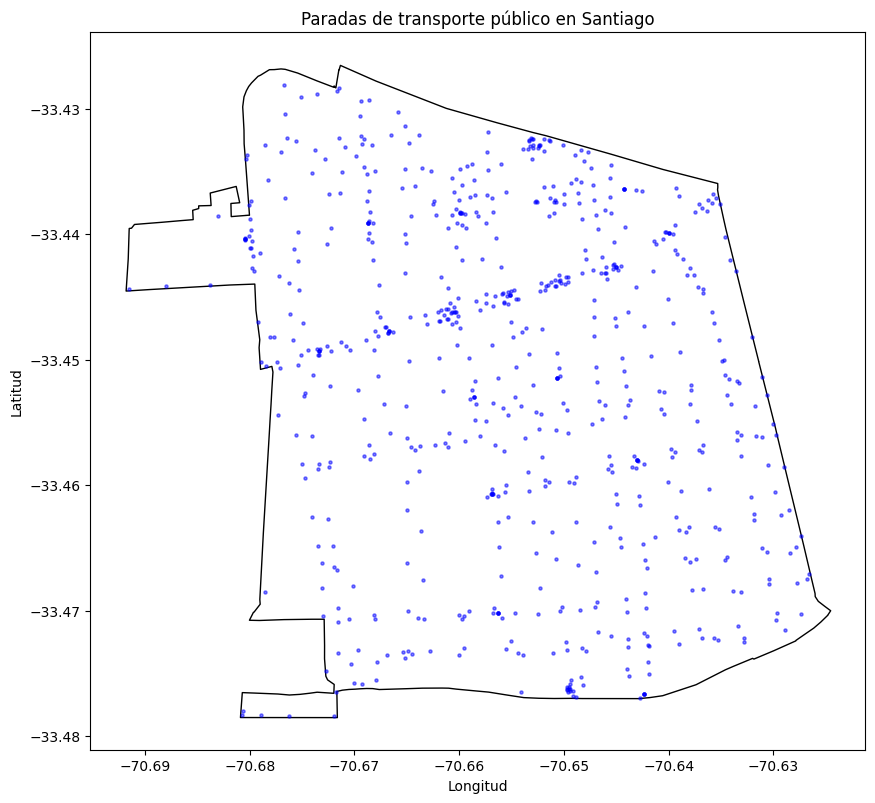

In [113]:
#3. Visualizamos las paradas en un mapa
fig, ax = plt.subplots(figsize = (10, 10))

# Dibujar mapa base de regiones
mapa_santiago.plot(ax = ax, color = "white", edgecolor = "black")

# Dibujar puntos de paradas
gdf_paradas_santiago.plot(ax = ax, markersize = 5, color = "blue", alpha = 0.5)

plt.title("Paradas de transporte público en Santiago", fontsize = 12)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()